# Detect alternative TSS/CTSS

In order to detect the alternative TSS or CTSS, we directly exploit [BRIE2](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-021-02461-5) which is based on a Bayesian hierarchical model. 

We should make preprocessing for our TSS data from CamoTSS.   

## prepare h5ad file

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import scanpy as sc
import numpy as np

Here, we can first read the count matrix which has **genes with multiple TSSs** from the CamoTSS_out file. 

In [6]:
TSSadata=sc.read('/storage/yhhuang/users/ruiyan/NPC/srafiledir/scTSS_out/all_unannotation/count/scTSS_count_two.h5ad')
TSSadata

AnnData object with n_obs × n_vars = 51001 × 4226
    var: 'TSS_start', 'TSS_end', 'gene_id', 'Chromosome', 'Feature', 'Start', 'End', 'Strand', 'gene_name', 'len'

`expadata` is the expression data which can be obtained from either cellranger count or adding annotation by yourself. 

In [7]:
expadata=sc.read('/storage/yhhuang/users/ruiyan/NPC/srafiledir/cellranger_change_index/all_cellranger_NPC.h5ad')
expadata

AnnData object with n_obs × n_vars = 3863735 × 33538
    obs: 'index', 'cell_id', 'batch'
    var: 'gene_ids', 'feature_types'

In order to build relationship with TSS data, we should first keep the `var.index` the same with the prefix of TSS id

In [8]:
expadata.var['gene_name']=expadata.var.index
expadata.var.index=expadata.var['gene_ids']
expadata.var

,gene_ids,feature_types,gene_name
gene_ids,,,
ENSG00000243485,ENSG00000243485,Gene Expression,MIR1302-2HG
ENSG00000237613,ENSG00000237613,Gene Expression,FAM138A
ENSG00000186092,ENSG00000186092,Gene Expression,OR4F5
ENSG00000238009,ENSG00000238009,Gene Expression,AL627309.1
ENSG00000239945,ENSG00000239945,Gene Expression,AL627309.3
...,...,...,...
ENSG00000277856,ENSG00000277856,Gene Expression,AC233755.2
ENSG00000275063,ENSG00000275063,Gene Expression,AC233755.1
ENSG00000271254,ENSG00000271254,Gene Expression,AC240274.1


To make sure the `cell barcode` unique

In [9]:
expadata.obs_names_make_unique()
expadata

AnnData object with n_obs × n_vars = 3863735 × 33538
    obs: 'index', 'cell_id', 'batch'
    var: 'gene_ids', 'feature_types', 'gene_name'

#### Select the TSS with max count

In [10]:
genedf=adata.var.copy()
genedf

,TSS_start,TSS_end,gene_id,Chromosome,Feature,Start,End,Strand,gene_name,len
transcript_id,,,,,,,,,,
ENSG00000197530_newTSS,1629591,1629697,ENSG00000197530,1,gene,1615414,1630610,+,MIB2,15196
ENSG00000197530_ENST00000518681,1615420,1615554,ENSG00000197530,1,gene,1615414,1630610,+,MIB2,15196
ENSG00000197530_ENST00000510793,1616194,1616348,ENSG00000197530,1,gene,1615414,1630610,+,MIB2,15196
ENSG00000189409_ENST00000435358,1633111,1633230,ENSG00000189409,1,gene,1632162,1635263,+,MMP23B,3101
ENSG00000189409_ENST00000472264,1632164,1632228,ENSG00000189409,1,gene,1632162,1635263,+,MMP23B,3101
...,...,...,...,...,...,...,...,...,...,...
ENSG00000089820_ENST00000461052,153926592,153926836,ENSG00000089820,X,gene,153907366,153934999,-,ARHGAP4,27633
ENSG00000013563_newTSS,154411909,154412002,ENSG00000013563,X,gene,154401235,154412112,-,DNASE1L1,10877
ENSG00000013563_ENST00000369807,154409083,154409253,ENSG00000013563,X,gene,154401235,154412112,-,DNASE1L1,10877


In [11]:
genedf['count']=np.sum(adata.X,axis=0)
genedf

,TSS_start,TSS_end,gene_id,Chromosome,Feature,Start,End,Strand,gene_name,len,count
transcript_id,,,,,,,,,,,
ENSG00000197530_newTSS,1629591,1629697,ENSG00000197530,1,gene,1615414,1630610,+,MIB2,15196,149.0
ENSG00000197530_ENST00000518681,1615420,1615554,ENSG00000197530,1,gene,1615414,1630610,+,MIB2,15196,521.0
ENSG00000197530_ENST00000510793,1616194,1616348,ENSG00000197530,1,gene,1615414,1630610,+,MIB2,15196,59.0
ENSG00000189409_ENST00000435358,1633111,1633230,ENSG00000189409,1,gene,1632162,1635263,+,MMP23B,3101,117.0
ENSG00000189409_ENST00000472264,1632164,1632228,ENSG00000189409,1,gene,1632162,1635263,+,MMP23B,3101,96.0
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000089820_ENST00000461052,153926592,153926836,ENSG00000089820,X,gene,153907366,153934999,-,ARHGAP4,27633,127.0
ENSG00000013563_newTSS,154411909,154412002,ENSG00000013563,X,gene,154401235,154412112,-,DNASE1L1,10877,901.0
ENSG00000013563_ENST00000369807,154409083,154409253,ENSG00000013563,X,gene,154401235,154412112,-,DNASE1L1,10877,838.0


In [12]:
keepdf=genedf.sort_values(['gene_id','count']).groupby('gene_id').tail(2)
keepdf

,TSS_start,TSS_end,gene_id,Chromosome,Feature,Start,End,Strand,gene_name,len,count
transcript_id,,,,,,,,,,,
ENSG00000000460_newTSS,169683373,169683419,ENSG00000000460,1,gene,169662006,169854080,+,C1orf112,192074,418.0
ENSG00000000460_ENST00000359326,169794958,169795195,ENSG00000000460,1,gene,169662006,169854080,+,C1orf112,192074,751.0
ENSG00000000938_newTSS,27626457,27626515,ENSG00000000938,1,gene,27612063,27635185,-,FGR,23122,325.0
ENSG00000000938_ENST00000457296,27626045,27626174,ENSG00000000938,1,gene,27612063,27635185,-,FGR,23122,732.0
ENSG00000001167_newTSS,41080778,41080854,ENSG00000001167,6,gene,41072944,41099976,+,NFYA,27032,103.0
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000284691_ENST00000641717,150405407,150405450,ENSG00000284691,7,gene,150400701,150412470,+,AC073111.4,11769,100.0
ENSG00000285077_ENST00000567449,30624493,30624569,ENSG00000285077,15,gene,30624493,30649529,+,AC091057.6,25036,55.0
ENSG00000285077_newTSS,30626051,30626146,ENSG00000285077,15,gene,30624493,30649529,+,AC091057.6,25036,421.0


In [13]:
firstdf=keepdf[::2]
firstdf

,TSS_start,TSS_end,gene_id,Chromosome,Feature,Start,End,Strand,gene_name,len,count
transcript_id,,,,,,,,,,,
ENSG00000000460_newTSS,169683373,169683419,ENSG00000000460,1,gene,169662006,169854080,+,C1orf112,192074,418.0
ENSG00000000938_newTSS,27626457,27626515,ENSG00000000938,1,gene,27612063,27635185,-,FGR,23122,325.0
ENSG00000001167_newTSS,41080778,41080854,ENSG00000001167,6,gene,41072944,41099976,+,NFYA,27032,103.0
ENSG00000001460_newTSS,24413671,24413692,ENSG00000001460,1,gene,24356998,24416934,-,STPG1,59936,57.0
ENSG00000001631_newTSS,92245433,92245509,ENSG00000001631,7,gene,92198968,92246166,-,KRIT1,47198,142.0
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278558_newTSS,18528598,18528654,ENSG00000278558,22,gene,18527801,18530573,+,TMEM191B,2772,97.0
ENSG00000278709_newTSS,57710609,57710825,ENSG00000278709,20,gene,57710155,57712780,+,NKILA,2625,71.0
ENSG00000284691_newTSS,150408026,150408165,ENSG00000284691,7,gene,150400701,150412470,+,AC073111.4,11769,93.0


In [14]:
seconddf=keepdf[1::2]
seconddf

,TSS_start,TSS_end,gene_id,Chromosome,Feature,Start,End,Strand,gene_name,len,count
transcript_id,,,,,,,,,,,
ENSG00000000460_ENST00000359326,169794958,169795195,ENSG00000000460,1,gene,169662006,169854080,+,C1orf112,192074,751.0
ENSG00000000938_ENST00000457296,27626045,27626174,ENSG00000000938,1,gene,27612063,27635185,-,FGR,23122,732.0
ENSG00000001167_ENST00000341376,41072944,41073076,ENSG00000001167,6,gene,41072944,41099976,+,NFYA,27032,2039.0
ENSG00000001460_ENST00000483261,24391926,24392095,ENSG00000001460,1,gene,24356998,24416934,-,STPG1,59936,58.0
ENSG00000001631_ENST00000412043,92245674,92245834,ENSG00000001631,7,gene,92198968,92246166,-,KRIT1,47198,4188.0
...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000278558_ENST00000618859,18529298,18529492,ENSG00000278558,22,gene,18527801,18530573,+,TMEM191B,2772,358.0
ENSG00000278709_ENST00000614771,57710157,57710345,ENSG00000278709,20,gene,57710155,57712780,+,NKILA,2625,495.0
ENSG00000284691_ENST00000641717,150405407,150405450,ENSG00000284691,7,gene,150400701,150412470,+,AC073111.4,11769,100.0


Get the expression data with the same cell and same genes as TSS adata

In [19]:
keepexpadata=expadata[adata.obs.index.tolist(),seconddf['gene_id'].tolist()]
keepexpadata

View of AnnData object with n_obs × n_vars = 51001 × 1784
    obs: 'index', 'cell_id', 'batch'
    var: 'gene_ids', 'feature_types', 'gene_name'

In [20]:
keepexpadata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

Add `isoform1` and `isoform2` to the layer of expression data and add the name of `isoform1` and the name of `isoform2` to the gene name

In [21]:
isoform1adata=TSSadata[:,firstdf.index.tolist()]
isoform1adata

View of AnnData object with n_obs × n_vars = 51001 × 1784
    var: 'TSS_start', 'TSS_end', 'gene_id', 'Chromosome', 'Feature', 'Start', 'End', 'Strand', 'gene_name', 'len'

In [23]:
isoform1adata.X

ArrayView([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
isoform2adata=TSSadata[:,seconddf.index.tolist()]
isoform2adata

View of AnnData object with n_obs × n_vars = 51001 × 1784
    var: 'TSS_start', 'TSS_end', 'gene_id', 'Chromosome', 'Feature', 'Start', 'End', 'Strand', 'gene_name', 'len'

In [24]:
isoform2adata.X

ArrayView([[0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 1.],
           ...,
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 0.],
           [0., 0., 0., ..., 0., 0., 2.]], dtype=float32)

In [25]:
keepexpadata.layers['isoform1']=isoform1adata.X
keepexpadata.layers['isoform2']=isoform2adata.X

In [26]:
keepexpadata.var['isoform1_name']=isoform1adata.var.index.values
keepexpadata.var['isoform2_name']=isoform2adata.var.index.values

We did not the `ambiguous` count value, so we set them as zero.

In [27]:
keepexpadata.layers['ambiguous']=np.zeros((51001, 1784))
keepexpadata

AnnData object with n_obs × n_vars = 51001 × 1784
    obs: 'index', 'cell_id', 'batch'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name'
    layers: 'isoform1', 'isoform2', 'ambiguous'

In order to run BRIE2 smoothly, we set the type of data as `float32`

In [28]:
keepexpadata.X=keepexpadata.X.astype('float32')
keepexpadata.layers['isoform1']=keepexpadata.layers['isoform1'].astype('float32')
keepexpadata.layers['isoform2']=keepexpadata.layers['isoform2'].astype('float32')
keepexpadata.layers['ambiguous']=keepexpadata.layers['ambiguous'].astype('float32')

Please make sure the expression profile of `keepexpadata` is raw data and the counts of `isoform1` and `isoform2` are also **raw data** 

In [29]:
keepexpadata.X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [30]:
keepexpadata.layers['isoform1'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [31]:
keepexpadata.layers['isoform2'].toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 2.]], dtype=float32)

In [ ]:
keepexpadata.write('/storage/yhhuang/users/ruiyan/NPC/express_to_brie.h5ad')

## Get h5ad file for each cell type
Actually, here, we can get the alternative TSS usage for each cell type between `NLH` and `NPC` (two conditions).

In another words, the number that you need run BRIE2 is the same with the number of cell type. 

So you need to do cell annotation for these cells and then separate them to get h5ad file for each cell types.

In [33]:
annodata=sc.read('/storage/yhhuang/users/ruiyan/NPC/srafiledir/scTSS_out/NPC_new_normalized.h5ad')
annodata

AnnData object with n_obs × n_vars = 51001 × 4226
    obs: 'cluster', 'UMAP_1', 'UMAP_2', 'patient_ID', 'condition'
    var: 'TSS_start', 'TSS_end', 'gene_id', 'Chromosome', 'Feature', 'Start', 'End', 'Strand', 'gene_name', 'len'
    uns: 'log1p'
    obsm: 'X_umap'
    layers: 'counts'

Map `cell type` information for each cell

In [34]:
keepexpadata.obs['cluster']=annodata.obs.index.map(annodata.obs['cluster'])
keepexpadata

AnnData object with n_obs × n_vars = 51001 × 1784
    obs: 'index', 'cell_id', 'batch', 'cluster'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name'
    layers: 'isoform1', 'isoform2', 'ambiguous'

**Note** Please replace the path with your own path to store all h5ad file of cell type

In [36]:
def get_celltype_adata(cellType):
    celltypeadata=keepexpadata[keepexpadata.obs['cluster']==cellType,:]
    celltype=cellType.replace(' ','_')
    file=celltype+'.h5ad'
    outputpath=os.path.join('/storage/yhhuang/users/ruiyan/NPC/diffcluster/',file)
    celltypeadata.write(outputpath)


In [ ]:
for celltype in keepexpadata.obs['cluster'].unique():
    get_celltype_adata(celltype)

## Get Cdr file for each cell type
The cdr file means the cell detected rate file. That is the proportion of gene in the all genes for this cell. 

For different scenarios, it includes different columns. 

If you want to compare two conditions, such as `NLH` and `NPC`, then you just give one column to tell BRIE2 that it is NLH or not. 

If you want to campare multiple conditions, such as `skin`,`brain` and `spleen`, then you should give binary value for all of these organs. 


In [38]:
import pandas as pd
import scanpy as sc
import numpy as np
import os


In [39]:
keepexpadata=sc.read('/storage/yhhuang/users/ruiyan/NPC/express_to_brie.h5ad')
keepexpadata

AnnData object with n_obs × n_vars = 51001 × 1784
    obs: 'index', 'cell_id', 'batch'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name'
    layers: 'ambiguous', 'isoform1', 'isoform2'

In [40]:
def get_cdr_file(cellcluster):
    cellcluster=cellcluster.replace(' ','_')
    inputfile='/storage/yhhuang/users/ruiyan/NPC/diffcluster/'+str(cellcluster)+'.h5ad'
    clusteradata=sc.read(inputfile)
    diseasedf=pd.DataFrame(clusteradata.obs['condition'])
    cdrdiseasedf = pd.get_dummies(diseasedf.condition, prefix='disease')
    
    cdr=np.array((clusteradata.X > 0).mean(1))[:,0]
    cdrdiseasedf['detect_rate']=cdr
    cdrdiseasedf.reset_index(inplace=True)
    

    cdrdiseasedf.drop(labels=['disease_NLH'],axis=1,inplace=True)
    print(cdrdiseasedf)
    outfile='/storage/yhhuang/users/ruiyan/NPC/diffcluster/NPC_cdr_'+cellcluster+'.tsv'
    cdrdiseasedf.to_csv(outfile,sep='\t',index=None)

In [ ]:
for celltype in adata.obs['cluster'].unique():
    get_cdr_file(celltype)

## Run BRIE2

Here, we write a for loop for each cell type to run BRIE2

For more information about BRIE2, you can check this [tutorial](https://brie.readthedocs.io/en/latest/)

In [ ]:
#!/bin/bash

arr=(NK Myeloids Epithelial Fibroblast T_cells B_cells)
for i in ${arr[@]}
do
echao $i
brie-quant -i /storage/yhhuang/users/ruiyan/NPC/diffcluster/${i}.h5ad   -c /storage/yhhuang/users/ruiyan/NPC/diffcluster/NPC_cdr_${i}.tsv   -o /storage/yhhuang/users/ruiyan/NPC/diffcluster/Brie_out/brie_NPC_${i}.h5ad --batchSize 1000000 --minCell 10  --interceptMode gene --testBase full --LRTindex 0
done


## Filter genes with TSS shift between two conditions

Here, we set the threshold as `FDR<0.01` to filter genes with alternative TSS

In [41]:
import pandas as pd
import scanpy as sc

In [42]:
def get_sign_gene(celltype):
    celltype=celltype.replace(' ','_')
    inputfile='/storage/yhhuang/users/ruiyan/NPC/diffcluster/Brie_out/brie_NPC_'+celltype+'.brie_ident.tsv'
    briedf=pd.read_csv(inputfile,delimiter='\t')
    print(briedf)
    signTdf=briedf[briedf['disease_NPC_FDR']<0.01]
    outputfile='/storage/yhhuang/users/ruiyan/NPC/diffcluster/sign_Gene/'+celltype+'.csv'
    signTdf.to_csv(outputfile,index=None)

In [ ]:

for celltype in keepexpadata.obs['cluster'].unique():
    get_sign_gene(celltype)  

## Display gene with alternative TSS using valcano plot

For this part, you can also refer to [BRIE2 example](https://brie.readthedocs.io/en/latest/brie2_scNTseq.html).

In [43]:
import brie
import scanpy as sc
import matplotlib.pyplot as plt

In [44]:
print(brie.__version__)

2.2.0


In [45]:
adata=sc.read('/storage/yhhuang/users/ruiyan/NPC/diffcluster/Brie_out/brie_NPC_T_cells.h5ad')
adata

AnnData object with n_obs × n_vars = 24571 × 1628
    obs: 'cluster', 'UMAP_1', 'UMAP_2', 'patient_ID', 'condition'
    var: 'gene_ids', 'feature_types', 'gene_name', 'isoform1_name', 'isoform2_name', 'n_counts', 'n_counts_uniq', 'loss_gene'
    uns: 'Xc_ids', 'brie_losses', 'brie_param', 'brie_version'
    obsm: 'Xc'
    varm: 'ELBO_gain', 'cell_coeff', 'fdr', 'intercept', 'pval', 'sigma'
    layers: 'Psi', 'Psi_95CI', 'Z_std', 'ambiguous', 'isoform1', 'isoform2'

In [46]:
adata.uns['brie_param']

{'LRT_index': array([0]),
 'base_mode': 'full',
 'intercept_mode': 'gene',
 'layer_keys': array(['isoform1', 'isoform2', 'ambiguous'], dtype=object),
 'pseudo_count': 0.01}

In [47]:
#Change gene index from Ensemebl id to gene name

adata.var.index=adata.var['gene_name']
adata.var.index

Index(['C1orf112', 'FGR', 'NFYA', 'STPG1', 'KRIT1', 'SNX11', 'CASP10', 'CFLAR',
       'SARM1', 'FKBP4',
       ...
       'UHRF1', 'CCL4L2', 'MYO19', 'GGNBP2', 'ACACA', 'TMEM191B', 'NKILA',
       'AC073111.5', 'ARHGAP11B', 'AC016831.7'],
      dtype='object', name='gene_name', length=1628)

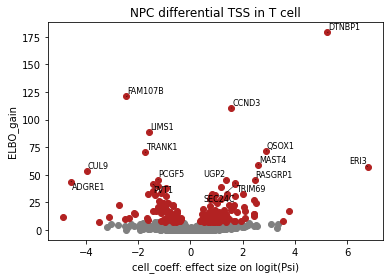

In [49]:
## volcano plot for differential splicing events
#fig = plt.figure(figsize=(4.5, 3.5), dpi=300)
brie.pl.volcano(adata, y='ELBO_gain', log_y=False, n_anno=16, score_red=7, adjust=True)
plt.xlabel('cell_coeff: effect size on logit(Psi)')
plt.title("NPC differential TSS in T cell")
#fig.savefig('/storage/yhhuang/users/ruiyan/figure/figure5/T_volcano.pdf',bbox_inches='tight',dpi=300)
plt.show()